In [32]:
#working with classification on pytorch
import torch
from torch import nn
import matplotlib.pyplot as plt

In [33]:
#making a toy classification dataset
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [34]:
len(X), len(y)

(1000, 1000)

In [35]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [36]:
print(y[:5])

[1 1 1 1 0]


In [37]:
import pandas as pd

df = pd.DataFrame({'X1:': X[:, 0],
                   'X2': X[:, 1],
                   'label': y})

In [38]:
df.head()

X1:        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

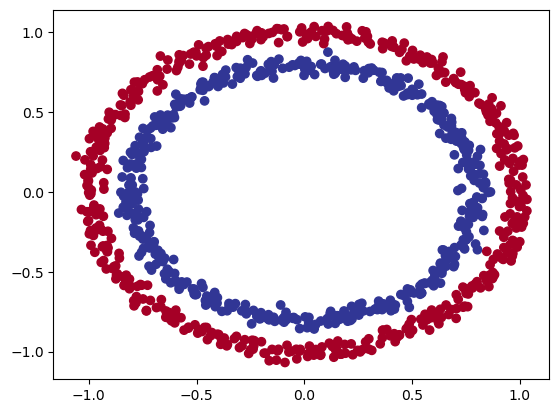

In [39]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [40]:
#turning data into tensors

X.shape, y.shape

((1000, 2), (1000,))

In [41]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [42]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [43]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [44]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [47]:
#setting up device agnostic code

device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [48]:
#creating a model
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Linear(in_features=8, out_features=1)
        )

    def forward(self, x):
        return self.two_linear_layers(x)

model = ClassificationModel().to(device)
model


ClassificationModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [49]:
next(model.parameters()).device

device(type='mps', index=0)

In [50]:
model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='mps:0')),
             ('two_linear_layers.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='mps:0')),
             ('two_linear_layers.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]],
                     device='mps:0')),
             ('two_linear_layers.1.bias', tensor([0.2730], device='mps:0'))])

In [51]:
#make predictions
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))
print(f'Length: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length: {len(X_test)}, Shape: {X_test.shape}')
print(f'First 10 predictions: {torch.round(untrained_preds[:10])}')
print(f'First 10 labels: {y_test[:10]}')

Length: 200, Shape: torch.Size([200, 1])
Length: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [52]:
#setting up a loss function and optimizers
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [53]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [54]:
#calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [55]:
#training our model
#going from raw logits to prediction probabilities
model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967]], device='mps:0')

In [56]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [57]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]], device='mps:0')

In [58]:
y_preds = torch.round(y_pred_prob)
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 1., 0., 1.], device='mps:0')

In [59]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits_1 = model(X_train).squeeze()
    y_pred_1 = torch.round(torch.sigmoid(y_logits_1))
    loss = loss_fn(y_logits_1, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred_1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))
        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=y_pred_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.70544, Accuracy: 48.25 | Test Loss: 0.69489, Test Accuracy: 53.00
Epoch: 10 | Loss: 0.70482, Accuracy: 48.25 | Test Loss: 0.69443, Test Accuracy: 53.50
Epoch: 20 | Loss: 0.70425, Accuracy: 48.38 | Test Loss: 0.69402, Test Accuracy: 54.00
Epoch: 30 | Loss: 0.70372, Accuracy: 48.25 | Test Loss: 0.69365, Test Accuracy: 53.50
Epoch: 40 | Loss: 0.70323, Accuracy: 48.00 | Test Loss: 0.69331, Test Accuracy: 53.00
Epoch: 50 | Loss: 0.70278, Accuracy: 48.00 | Test Loss: 0.69301, Test Accuracy: 53.00
Epoch: 60 | Loss: 0.70236, Accuracy: 47.88 | Test Loss: 0.69274, Test Accuracy: 53.00
Epoch: 70 | Loss: 0.70196, Accuracy: 48.25 | Test Loss: 0.69250, Test Accuracy: 52.00
Epoch: 80 | Loss: 0.70159, Accuracy: 48.25 | Test Loss: 0.69228, Test Accuracy: 52.50
Epoch: 90 | Loss: 0.70125, Accuracy: 48.25 | Test Loss: 0.69209, Test Accuracy: 52.50
Epoch: 100 | Loss: 0.70092, Accuracy: 48.50 | Test Loss: 0.69191, Test Accuracy: 53.00
Epoch: 110 | Loss: 0.70062, Accuracy: 48.62 | Test Los